In [ ]:
if "_first_run" not in globals():
    _first_run = True
else:
    _first_run = False

In [7]:
if _first_run:
    import os
    from pathlib import Path
    import torch
    from tqdm import tqdm
    import warnings
    import re
    import keras
    import librosa
    import numpy as np
    from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
    import random
    import soundfile as sf
    import shutil
    from sklearn.model_selection import KFold

### Use cuda acceleration (optional)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Remove existing augmented data

In [9]:

path = './AUDIO_DATA'

if os.path.exists('./augmented_train_dataset'):
    shutil.rmtree('./augmented_train_dataset')

if os.path.exists('./augmented_test_dataset'):
    shutil.rmtree('./augmented_test_dataset')

### Link your google drive storage if you are working on google colab (optional)  

In [10]:
# path = '<your google drive path>'
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/DurianAudios

In [11]:
# seed = 41
# random.seed(seed), np.random.seed(seed), tf.random.set_seed(seed)

In [12]:
AUDIO_PATH = Path("./AUDIO_DATA")
assert AUDIO_PATH.exists(), f"Audio path {AUDIO_PATH} does not exist."
AUDIO_LIST = list(AUDIO_PATH.glob("*"))
print(*AUDIO_LIST)

AUDIO_DATA\20240929_023338_Dona_75-85%output.wav AUDIO_DATA\20240929_023344_Dona_75-85%output.wav AUDIO_DATA\20240929_023348_Dona_75-85%output.wav AUDIO_DATA\20240929_023353_Dona_75-85%output.wav AUDIO_DATA\20240929_023359_Dona_75-85%output.wav AUDIO_DATA\20240929_023409_Dona_75-85%output.wav AUDIO_DATA\20240929_023414_Dona_75-85%output.wav AUDIO_DATA\20240929_023418_Dona_75-85%output.wav AUDIO_DATA\20240929_023426_Dona_75-85%output.wav AUDIO_DATA\20240929_023431_Dona_75-85%output.wav AUDIO_DATA\20240929_023435_Dona_75-85%output.wav AUDIO_DATA\20240929_023439_Dona_75-85%output.wav AUDIO_DATA\20240929_023443_Dona_75-85%output.wav AUDIO_DATA\20240929_023447_Dona_75-85%output.wav AUDIO_DATA\20240929_023501_Dona_75-85%output.wav AUDIO_DATA\20240929_023505_Dona_75-85%output.wav AUDIO_DATA\20240929_023509_Dona_75-85%output.wav AUDIO_DATA\20240929_023513_Dona_75-85%output.wav AUDIO_DATA\20240929_023517_Dona_75-85%output.wav AUDIO_DATA\20240929_023521_Dona_75-85%output.wav AUDIO_DATA\20240929_

## Filter audios by label

In [13]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="PySoundFile failed.*")

audios_75_85: list[Path] = []
audios_95: list[Path] = []

def tri_audio(audio: Path):
  if(audio.name not in [*audios_75_85,*audios_95]):
    try:
      if(re.split('_|%',audio.name)[3] == "75-85"):
        audios_75_85.append(audio)
      else:
        audios_95.append(audio)
    except:
      print(audio.name)
for i in sorted(AUDIO_LIST):
  tri_audio(i)

len(audios_75_85), len(audios_95)

(45, 47)

In [14]:
from sklearn.model_selection import train_test_split

# Séparer la liste AUDIO_LIST en train et test avant toute data augmentation
# train_files, test_files = train_test_split(audios_95 + audios_75_85, test_size=0.2, random_state=42, shuffle=True)
# train_files_2, test_files_2 = train_test_split(audios_75_85, test_size=0.2, random_state=42, shuffle=True)

# train_files = train_files_1 + train_files_2
# random.shuffle(train_files)
# test_files = test_files_1 + test_files_2
# print(f"{len(train_files)} training files and {len(test_files)} testing files.")

In [15]:
x_files = [Path(i) for i in audios_75_85 + audios_95]
# test_files = [Path(i) for i in test_files]
assert False not in [i.exists() for i in x_files], "Some training files do not exist."
# assert False not in [i.exists() for i in test_files], "Some testing files do not exist."

In [16]:
len([f for f in x_files if "95" in f.name]), len([f for f in x_files if "75-85" in f.name])

(48, 45)

# **2. Data Augmentation**
---

In [17]:
augment = [
    AddGaussianNoise(min_amplitude=0.000001, max_amplitude=0.00001, p=0.5),
    TimeStretch(min_rate=0.99, max_rate=1.01, p=0.5),
    PitchShift(min_semitones=-0.1, max_semitones=0.1, p=0.5),
]

composed = Compose(augment)

In [18]:
out_train_path = Path("./augmented_train_dataset")

In [19]:
os.mkdir(out_train_path)

In [20]:
def augment_audio(audio_path, output_path, augmentations, use_one=True, nb_copies=10):
    print("loading audios...")
    for file_path, (wave, sr) in tqdm([(audio, librosa.load(audio)) for audio in audio_path], desc="Augmenting audios"):
        for nb in range(nb_copies):
            chosen_aug = random.choice(augmentations) if use_one else composed
            wave_aug = chosen_aug(samples=wave, sample_rate=sr)  # type: ignore
            out = output_path / f"{file_path.name}_aug{nb}.wav"
            sf.write(out, wave_aug, sr)

In [21]:
augment_audio(x_files, out_train_path, augment, use_one=True, nb_copies=0)

loading audios...


Augmenting audios: 100%|██████████| 92/92 [00:00<00:00, 92138.48it/s]


# **3. Data and features extraction : MFCC**
---

In [22]:

# Liste des fichiers augmentés
augmented_train_files = sorted(Path(out_train_path).glob("*.wav"))

x_files_full = augmented_train_files + x_files

### Assert all path are correct

In [23]:
assert False not in list(map(lambda x: x.exists(), x_files_full))

In [24]:
print(f"{len(x_files_full)} train files")

92 train files


In [25]:
from typing import Iterable


n_mfcc     = 40        # number of coefficients
n_fft      = 2048      # window size STFT
hop_length = 512

def compute_mfcc(files: Iterable[Path]) -> Iterable[np.ndarray]:
  for file in files:
      y, sr = librosa.load(file, sr=None)
      mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
      yield librosa.util.normalize(mfcc_features, axis=1)

In [26]:
mfcc_train = [*compute_mfcc(tqdm(x_files_full, desc="Computing MFCCs for train files"))]

Computing MFCCs for train files: 100%|██████████| 92/92 [00:13<00:00,  6.91it/s]


# **4. Audio dataset preparation (padding and trimming)**
---

Besides, the idea is to set a single length T_max (typically the maximum recorded value) and then, for each MFCC:  
*   If T_i < T_max → pad with columns of trailing zeros
*   If T_i > T_max → trim to keep only the first T_max frames  

In [27]:
# Pour le train
T_train = [mfcc.shape[1] for mfcc in mfcc_train]
print("Durée (train) :", *T_train)

# T_max commun pour le padding (on prend le max des deux)
T_max = max(T_train)
print(f'The maximum value of time is {T_max} ms')

Durée (train) : 244 244 250 257 257 268 268 273 271 248 246 241 273 244 239 266 248 271 262 244 244 268 246 248 246 271 246 271 273 255 266 268 271 246 259 246 266 266 268 246 246 248 268 248 248 241 244 268 248 268 246 262 271 268 271 268 248 255 264 255 264 244 246 259 255 248 246 259 273 262 221 201 250 244 268 246 271 268 271 255 262 271 255 246 268 246 273 250 257 268 248 244
The maximum value of time is 273 ms


In this step, we ensure that all MFCCs have the same length by either padding them with zeros or trimming them to a fixed length, `T_max`. This is necessary to standardize the input size for the model.

In [28]:
def pad_mfccs(mfcc_list, T_max):
    mfcc_fixed = []
    for m in mfcc_list:
        T_i = m.shape[1]
        if T_i < T_max:
            pad_width = T_max - T_i
            m2 = np.pad(m,
                        pad_width=((0,0),   # no padding sur les coefficients
                        (0,pad_width)),     # padding à droite sur le temps
                        mode='constant',
                        constant_values=0)
        else:
            m2 = m[:, :T_max]
        mfcc_fixed.append(m2)
    return mfcc_fixed

# Pour le train
mfcc_train_fixed = pad_mfccs(mfcc_train, T_max)


# **5. Dataset formatting for model input**
---
At this stage, we will prepare our padded/truncated MFCCs into the right shape for our deep learning model (flattening, stacking, or reshaping as needed), and associate them with their corresponding labels.


In [29]:
x = np.stack(mfcc_train_fixed, axis=0)[..., np.newaxis]

print("X_train.shape =", x.shape)


X_train.shape = (92, 40, 273, 1)


# **6. Label and shuffle**
---

In [30]:
import re

def get_label(filename):
    base_name = re.sub(r'_aug\d+\.wav$', '', filename)
    if "75-85" in base_name:
        return 0  # unripe
    elif "95" in base_name:
        return 1  # ripe
    else:
        raise ValueError(f"Le nom de fichier ne permet pas d'extraire le label : {filename}")

# Recreate y_train and y_test with the new function
y = np.array([get_label(f) for f in map(lambda x: x.name, x_files_full)])

# Use class weight (optional, but useful for imbalanced datasets)
from numpy import dtype
from numpy._typing._array_like import NDArray
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

In [31]:
class_weights_dict

{0: np.float64(1.0222222222222221), 1: np.float64(0.9787234042553191)}

Shuffle training data ton ensure linear accuracy progress during training

In [32]:
# Shuffle le train pour éviter tout biais
idx = np.arange(x.shape[0])
np.random.shuffle(idx)
x = x[idx]
y = y[idx]

x_files_full = [x_files_full[i] for i in idx]# type: ignore

In [33]:
len([i for i in y if i == 0]), len([i for i in y if i == 1])

(45, 47)

### Ensure label corresponds to file name

In [34]:
error_indexes = [(index, b) for index, b in enumerate([bool(int("75-85" in i.name) != j) for i, j in zip(x_files_full, y)]) if not b]
assert len(error_indexes) == 0, f"Il y a {len(error_indexes)} erreurs dans les labels : {error_indexes}"

## K-folding training

In [ ]:
if _first_run:
    from keras.models import Sequential
    from keras.layers import Dense, Conv2D, Input, BatchNormalization, Dropout, MaxPooling2D, Flatten
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns
    import tensorflow as tf
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from keras.utils import to_categorical
    from sklearn.utils import class_weight
    from keras.utils import plot_model


In [36]:
def define_model():
    return Sequential([
        Input(shape=x.shape[1:]),
        Conv2D(32, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

In [37]:
def compile_model(model, learning_rate: int | None = None):
    if learning_rate is not None:
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return opt
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [38]:
def show_confusion_matrix(x, y_real, model, show=True):
    y_prob = model.predict(x).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_real, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Unripe', 'Ripe'], yticklabels=['Unripe', 'Ripe'])
    plt.xlabel("Prediction")
    plt.ylabel("Reality")
    plt.title("Confusion matrix")
    if(show):
        plt.show()

In [ ]:
k = 5
n_samples = len(x)

In [40]:
kf = KFold(n_splits=k, shuffle=True)

In [41]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [42]:
weight_ripe = 0.99
weight_overripe = 1 - weight_ripe
class_weights_dict = {0: weight_ripe, 1: weight_overripe}

In [43]:
# len(kf_split[0])

  0%|          | 0/10 [00:00<?, ?it/s]


Fold 0/10...
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
✅ Score Fold 0 : compile_metrics = 60.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 10%|█         | 1/10 [00:13<02:01, 13.55s/it]


Fold 1/10...
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
✅ Score Fold 1 : compile_metrics = 90.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 20%|██        | 2/10 [00:26<01:43, 12.96s/it]


Fold 2/10...
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
✅ Score Fold 2 : compile_metrics = 66.67%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 30%|███       | 3/10 [00:36<01:21, 11.63s/it]


Fold 3/10...
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
✅ Score Fold 3 : compile_metrics = 66.67%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 40%|████      | 4/10 [00:46<01:06, 11.15s/it]


Fold 4/10...
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
✅ Score Fold 4 : compile_metrics = 88.89%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 50%|█████     | 5/10 [00:57<00:56, 11.24s/it]


Fold 5/10...
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
✅ Score Fold 5 : compile_metrics = 55.56%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 60%|██████    | 6/10 [01:08<00:44, 11.12s/it]


Fold 6/10...
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
✅ Score Fold 6 : compile_metrics = 55.56%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 70%|███████   | 7/10 [01:18<00:32, 10.76s/it]


Fold 7/10...
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
✅ Score Fold 7 : compile_metrics = 77.78%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 80%|████████  | 8/10 [01:29<00:21, 10.80s/it]


Fold 8/10...
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
✅ Score Fold 8 : compile_metrics = 77.78%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 90%|█████████ | 9/10 [01:41<00:11, 11.21s/it]


Fold 9/10...
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
✅ Score Fold 9 : compile_metrics = 55.56%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 90%|█████████ | 9/10 [01:54<00:12, 12.77s/it]


✅ Score moyen sur 10 folds : 69.44%
Meilleur score : 90.00%
Pire score : 55.56%


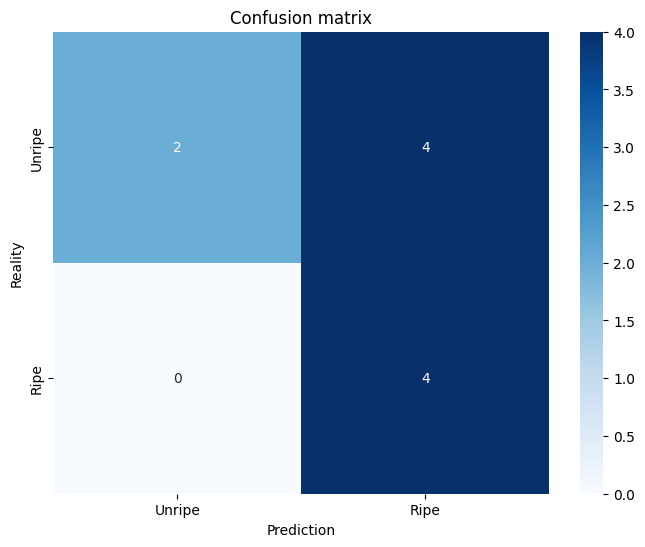

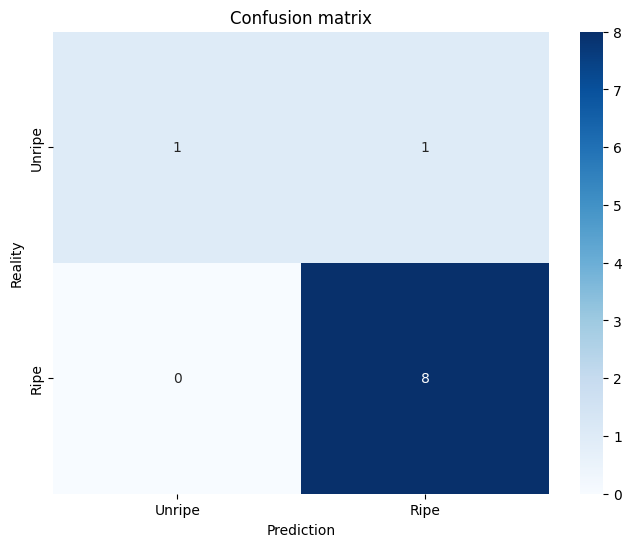

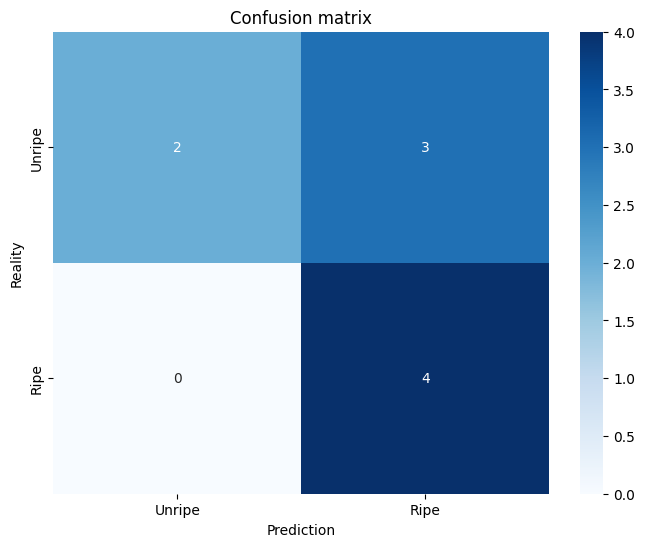

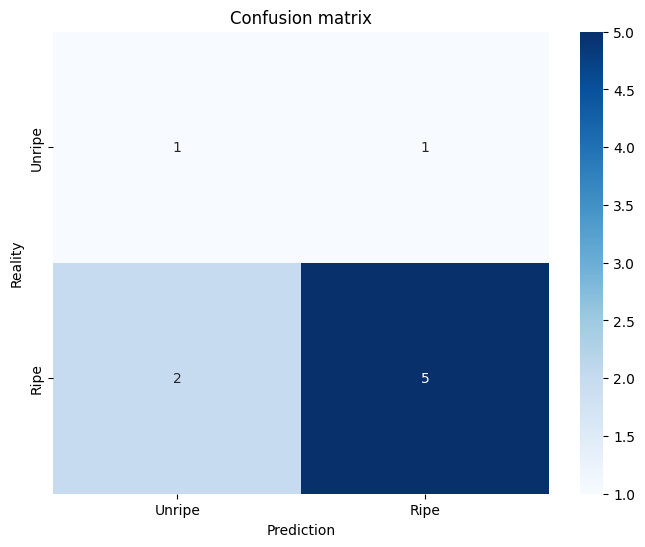

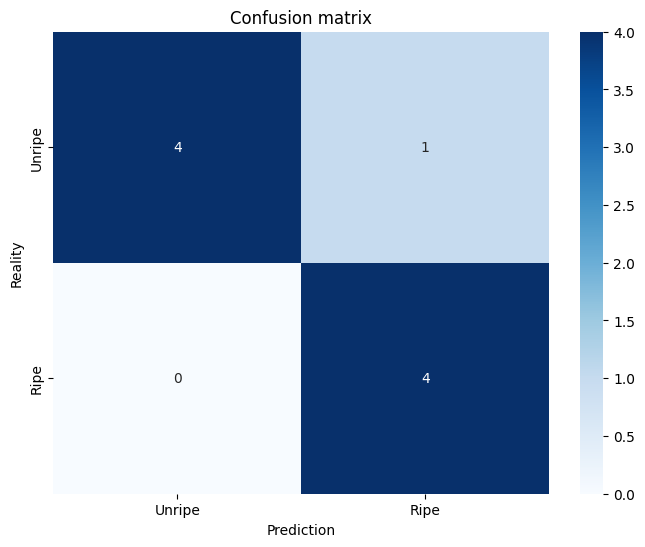

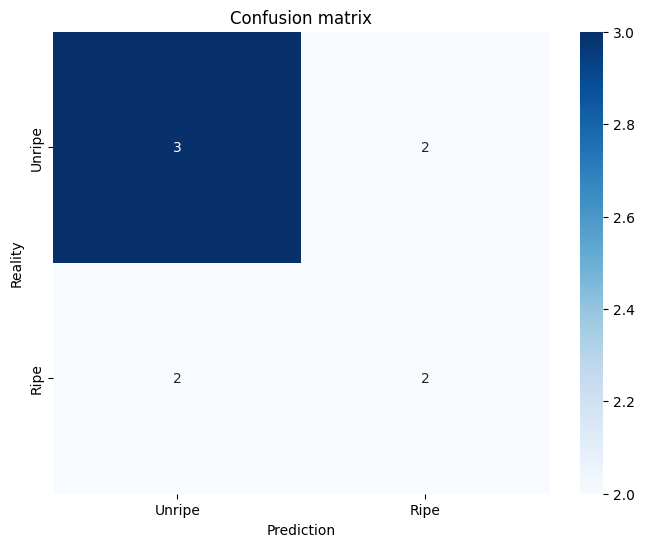

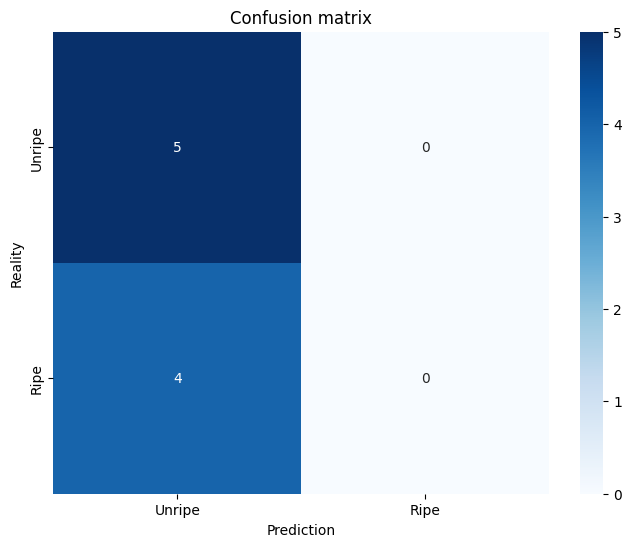

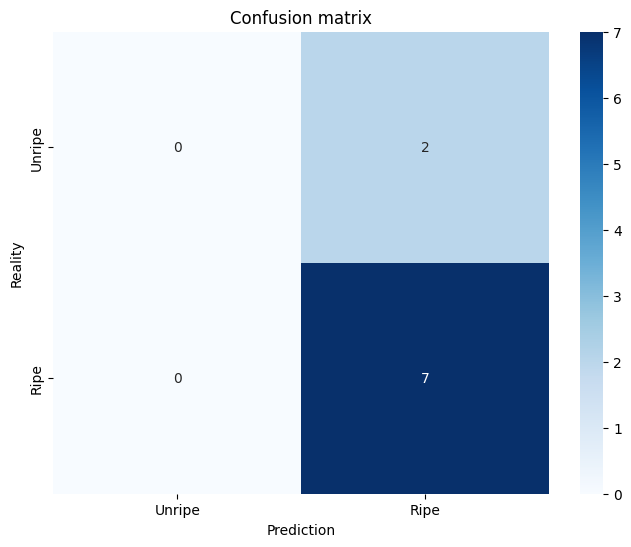

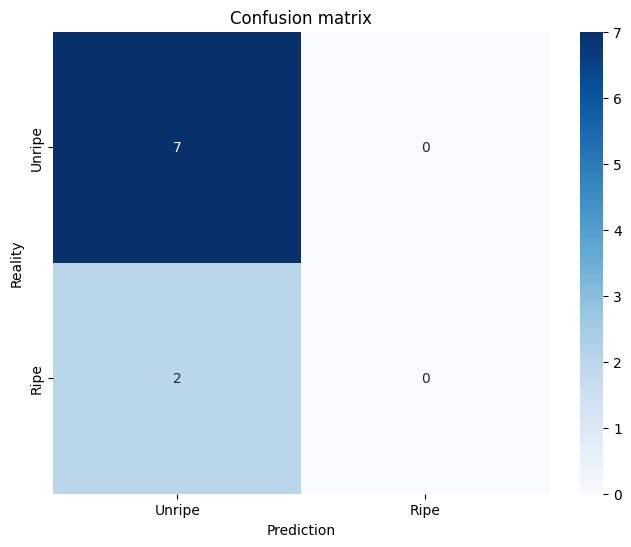

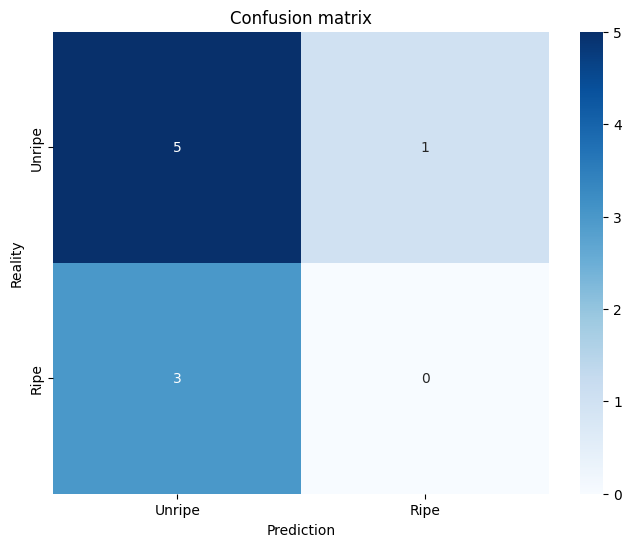

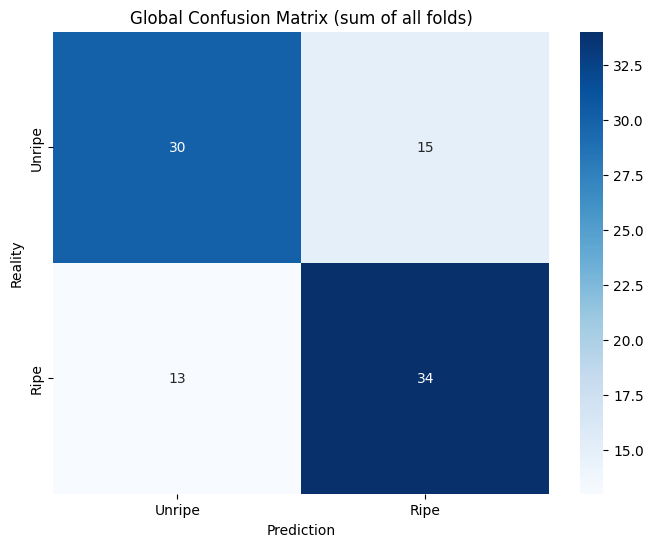

In [44]:
acc_per_fold = []
global_cm = np.zeros((2, 2), dtype=int)
kf_split = list(kf.split(x))
for (train_index, val_index), fold_no in zip(kf_split, tqdm(range(len(kf_split)))):
    print(f"\nFold {fold_no}/{k}...")
    
    X_train, X_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Calcul dynamique des class weights pour ce fold
    fold_class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    fold_class_weights_dict = dict(enumerate(fold_class_weights))
    
    model = define_model()
    compile_model(model)
    model.fit(
        X_train, y_train,
        epochs=15,
        batch_size=8,
        validation_data=(X_val, y_val),
        callbacks=[es, reduce_lr],
        class_weight=fold_class_weights_dict,
        verbose="0"
    )
    
    # --- Évaluation sur ce fold
    scores = model.evaluate(X_val, y_val, verbose="0")
    print(f"✅ Score Fold {fold_no} : {model.metrics_names[1]} = {scores[1]*100:.2f}%")
    y_prob = model.predict(X_val).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_val, y_pred)
    global_cm += cm
    show_confusion_matrix(X_val, y_val, model, show=False)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1
print(f"\n✅ Score moyen sur {k} folds : {np.mean(acc_per_fold):.2f}%")
print(f"Meilleur score : {np.max(acc_per_fold):.2f}%")
print(f"Pire score : {np.min(acc_per_fold):.2f}%")
plt.figure(figsize=(8, 6))
sns.heatmap(global_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unripe', 'Ripe'], yticklabels=['Unripe', 'Ripe'])
plt.xlabel("Prediction")
plt.ylabel("Reality")
plt.title("Global Confusion Matrix (sum of all folds)")
plt.show()

# **7. Building the classification model**
---
Now let's define our deep learning model. We'll use a simple Convolutional Neural Network (CNN) architecture suitable for audio classification.


In [45]:
compile_model(model)

# **6. Model training**
---
Let's train the model on the training data and keep track of its performance.


In [46]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
history = model.fit(
    x, y_train,
    epochs=15,
    batch_size=8,
    validation_split=0.2,
    callbacks=[es, reduce_lr],
    shuffle=True,
    class_weight=class_weights_dict  # Add class weights to compensate for slight class imbalance
)

Epoch 1/15
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5392 - loss: 4.1522

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 19
'y' sizes: 10


In [ ]:
x.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
show_confusion_matrix(x_test, y_test)

In [ ]:
show_confusion_matrix(x, y_train)

# **7. Model evaluation**
---
We now evaluate the trained model on the test set, check the accuracy, and display a confusion matrix for detailed analysis.


In [ ]:
loss, acc = model.evaluate(x_test, y_test)

# **8. Results & analysis**
---
Let's analyze the results, discuss strengths and weaknesses, and try to interpret what the model is learning.


In [ ]:
print("X_train.shape:", x.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", x_test.shape)
print("y_test.shape:", y_test.shape)

print("Répartition y_train :", np.unique(y_train, return_counts=True))
print("Répartition y_test :", np.unique(y_test, return_counts=True))

print("Premier fichier train:", train_files_final[0].name, "label:", y_train[0])
print("Premier fichier test:", test_files_final[0].name, "label:", y_test[0])

In [ ]:
print("y_train repartition :", np.bincount(y_train))
print("y_test repartition :", np.bincount(y_test))

In [ ]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:

# Confusion matrix
y_prob = model.predict(x_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ['unripe', 'ripe']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Prediction")
plt.ylabel("Reality")
plt.title("Confusion matrix")
plt.show()


In [ ]:

print(classification_report(y_test, y_pred, target_names=labels))



# **9. Save model**
---
Finally, we save our trained model for later use, and discuss possible improvements or future work.


In [ ]:
# only execute the first time 
model_version_index = 6

In [ ]:
model.save(f"models/model_augmented_v{model_version_index}_({loss:.2f}, {acc:.2f})_.keras")
model_version_index+=1

test